# Mean Field Game – Data-driven Pipeline

Este notebook calibra o modelo com dados da B3, executa o solver LQ e explica cada etapa de forma intuitiva.

In [7]:
# Ensure local package is importable without installation
import sys
from pathlib import Path

ROOT = Path().resolve().parent
SRC = ROOT / 'src'
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))


## Narrativa geral
- **Dados**: usamos COTAHIST limpo para extrair volatilidade, retornos, spreads e volume.
- **Calibração**: heurísticas ajustam `nu`, `phi`, `gamma_T`, `eta0`, `eta1`.
- **Solver**: executamos o Picard com salvaguardas.
- **Relatórios**: resultados são salvos em `notebooks_output/`.

In [8]:
from __future__ import annotations

import json
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

from IPython.display import display, Image
import pprint

from mfg_finance.grid import Grid1D
from mfg_finance.models.hft import HFTParams, eta_from_m_alpha, initial_density
from mfg_finance.price import solve_price_clearing
from mfg_finance.solver import solve_mfg_picard
from mfg_finance.viz import plot_alpha_cuts, plot_convergence, plot_density_time, plot_price, plot_value_time


## 1. Configuração de diretórios


In [9]:
ROOT = Path.cwd().parent
DATA_PROCESSED = ROOT / 'data' / 'processed'
OUTPUT_BASE = ROOT / 'notebooks_output'
OUTPUT_BASE.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime('run-%Y%m%d-%H%M%S')
REPORT_DIR = OUTPUT_BASE / timestamp
REPORT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Resultados serÃ£o salvos em: {REPORT_DIR}')
REPORT_DIR


Resultados serÃ£o salvos em: c:\Users\Cockles\Documents\GitHub\mfg-for-financial-market\notebooks_output\run-20251019-224426


WindowsPath('c:/Users/Cockles/Documents/GitHub/mfg-for-financial-market/notebooks_output/run-20251019-224426')

## 2. Calibração heurí­stica


## 2.1 Curva de oferta empírica
Quantis de volume e spread usados no clearing.

In [10]:
supply_path = DATA_PROCESSED / 'supply_curve.csv'
if supply_path.exists():
    supply_df = pd.read_csv(supply_path)
    print('Curva de oferta por quantil:')
    display(supply_df)
else:
    print('Arquivo supply_curve.csv nÃ£o encontrado; execute a calibração empÃírica.')


Curva de oferta por quantil:


,quantile,volume_shares,dollar_volume,spread_rel
0,0.10,7.720811e+01,4.525726e+03,0.000001
1,0.25,2.778425e+02,2.605614e+04,0.000555
2,0.50,1.638515e+03,1.009712e+05,0.007264
3,0.75,6.462602e+04,8.266747e+05,0.029996
4,0.90,1.583355e+06,1.956802e+07,0.099771


In [11]:
asset_summary = pd.read_csv(DATA_PROCESSED / 'cotahist_asset_summary.csv')
asset_summary = asset_summary.replace([np.inf, -np.inf], np.nan).dropna(subset=['std_log_return', 'annualised_vol'])
median_daily_std = float(asset_summary['std_log_return'].median())
median_annual_vol = float(asset_summary['annualised_vol'].median())
upper_quartile_vol = float(asset_summary['annualised_vol'].quantile(0.75))

nu = median_daily_std ** 2
phi = median_annual_vol / 20.0
gamma_T = upper_quartile_vol * 0.5

calibration_summary = {
    'median_daily_std': median_daily_std,
    'median_annual_vol': median_annual_vol,
    'upper_quartile_vol': upper_quartile_vol,
    'nu': round(nu, 6),
    'phi': round(phi, 6),
    'gamma_T': round(gamma_T, 6),
}
with open(REPORT_DIR / 'calibration.json', 'w', encoding='utf-8') as fp:
    json.dump(calibration_summary, fp, indent=2)
print('Calibração heurí­stica:')
print(json.dumps(calibration_summary, indent=2))
calibration_summary
calibration_df = pd.DataFrame([calibration_summary])
display(calibration_df)


Calibração heurí­stica:
{
  "median_daily_std": 0.0445486261341157,
  "median_annual_vol": 0.7071875160027775,
  "upper_quartile_vol": 1.137724647706284,
  "nu": 0.001985,
  "phi": 0.035359,
  "gamma_T": 0.568862
}


,median_daily_std,median_annual_vol,upper_quartile_vol,nu,phi,gamma_T
0,0.044549,0.707188,1.137725,0.001985,0.035359,0.568862


## 3. Atualizar baseline


In [13]:
baseline_path = ROOT / 'configs' / 'baseline.yaml'
with open(baseline_path, 'r', encoding='utf-8') as fp:
    baseline_cfg = yaml.safe_load(fp)
baseline_cfg.setdefault('params', {})
baseline_cfg['params']['nu'] = calibration_summary['nu']
baseline_cfg['params']['phi'] = calibration_summary['phi']
baseline_cfg['params']['gamma_T'] = calibration_summary['gamma_T']
with open(baseline_path, 'w', encoding='utf-8') as fp:
    yaml.safe_dump(baseline_cfg, fp, sort_keys=False)
print('Parametros atualizados do baseline:')
print(json.dumps(baseline_cfg['params'], indent=2))
baseline_cfg['params']
display(pd.DataFrame([baseline_cfg['params']]))


Parametros atualizados do baseline:
{
  "nu": 0.001985,
  "phi": 0.035359,
  "gamma_T": 0.568862,
  "eta0": 0.000555,
  "eta1": 0.029442,
  "m0_mean": 0.0,
  "m0_std": 1.0
}


,nu,phi,gamma_T,eta0,eta1,m0_mean,m0_std
0,0.001985,0.035359,0.568862,0.000555,0.029442,0.0,1.0


## 4. Construção do grid e parametros


In [14]:
grid_cfg = baseline_cfg['grid']
solver_cfg = baseline_cfg.get('solver', {})
params_cfg = baseline_cfg['params']
grid = Grid1D(
    x_min=float(grid_cfg['x_min']),
    x_max=float(grid_cfg['x_max']),
    nx=int(grid_cfg['nx']),
    T=float(grid_cfg['T']),
    nt=int(grid_cfg['nt']),
    bc=str(grid_cfg.get('bc', 'neumann')),
)
params = HFTParams(
    nu=float(params_cfg['nu']),
    phi=float(params_cfg['phi']),
    gamma_T=float(params_cfg['gamma_T']),
    eta0=float(params_cfg.get('eta0', 0.5)),
    eta1=float(params_cfg.get('eta1', 0.8)),
    m0_mean=float(params_cfg.get('m0_mean', 0.0)),
    m0_std=float(params_cfg.get('m0_std', 1.0)),
)
print('Grid configurado:')
print(grid)
print('Parametros HFT:')
print(params)
grid, params


Grid configurado:
Grid1D(x_min=-5.0, x_max=5.0, nx=201, T=0.5, nt=150, bc='neumann', dx=0.04999999999999982, dt=0.0033333333333333335, x=array([-5.  , -4.95, -4.9 , -4.85, -4.8 , -4.75, -4.7 , -4.65, -4.6 ,
       -4.55, -4.5 , -4.45, -4.4 , -4.35, -4.3 , -4.25, -4.2 , -4.15,
       -4.1 , -4.05, -4.  , -3.95, -3.9 , -3.85, -3.8 , -3.75, -3.7 ,
       -3.65, -3.6 , -3.55, -3.5 , -3.45, -3.4 , -3.35, -3.3 , -3.25,
       -3.2 , -3.15, -3.1 , -3.05, -3.  , -2.95, -2.9 , -2.85, -2.8 ,
       -2.75, -2.7 , -2.65, -2.6 , -2.55, -2.5 , -2.45, -2.4 , -2.35,
       -2.3 , -2.25, -2.2 , -2.15, -2.1 , -2.05, -2.  , -1.95, -1.9 ,
       -1.85, -1.8 , -1.75, -1.7 , -1.65, -1.6 , -1.55, -1.5 , -1.45,
       -1.4 , -1.35, -1.3 , -1.25, -1.2 , -1.15, -1.1 , -1.05, -1.  ,
       -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 , -0.55,
       -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
       -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
        0.4 ,  0.45,  0

(Grid1D(x_min=-5.0, x_max=5.0, nx=201, T=0.5, nt=150, bc='neumann', dx=0.04999999999999982, dt=0.0033333333333333335, x=array([-5.  , -4.95, -4.9 , -4.85, -4.8 , -4.75, -4.7 , -4.65, -4.6 ,
        -4.55, -4.5 , -4.45, -4.4 , -4.35, -4.3 , -4.25, -4.2 , -4.15,
        -4.1 , -4.05, -4.  , -3.95, -3.9 , -3.85, -3.8 , -3.75, -3.7 ,
        -3.65, -3.6 , -3.55, -3.5 , -3.45, -3.4 , -3.35, -3.3 , -3.25,
        -3.2 , -3.15, -3.1 , -3.05, -3.  , -2.95, -2.9 , -2.85, -2.8 ,
        -2.75, -2.7 , -2.65, -2.6 , -2.55, -2.5 , -2.45, -2.4 , -2.35,
        -2.3 , -2.25, -2.2 , -2.15, -2.1 , -2.05, -2.  , -1.95, -1.9 ,
        -1.85, -1.8 , -1.75, -1.7 , -1.65, -1.6 , -1.55, -1.5 , -1.45,
        -1.4 , -1.35, -1.3 , -1.25, -1.2 , -1.15, -1.1 , -1.05, -1.  ,
        -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 , -0.55,
        -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 , 

## 5. Executar solver


In [15]:
m0 = initial_density(grid, params)
hjb_kwargs = {
    'max_inner': 3,
    'tol': 1e-8,
    'max_dissipation': 1.0,
    'alpha_cap': 1.0,
    'value_cap': 40.0,
    'value_relaxation': 0.5,
}
solver_mix = float(solver_cfg.get('mix', 0.6))
U_all, M_all, alpha_all, errors, metrics = solve_mfg_picard(
    grid,
    params,
    max_iter=int(solver_cfg.get('max_iter', 120)),
    tol=float(solver_cfg.get('tol', 1e-6)),
    mix=solver_mix,
    m0=m0,
    hjb_kwargs=hjb_kwargs,
    eta_callback=eta_from_m_alpha,
)
run_metrics = {
    'iterations': len(errors),
    'final_error': float(errors[-1]) if errors else None,
    **metrics,
}
print('Metricas da simulacao:')
for k, v in run_metrics.items():
    print(f'  {k}: {v}')
run_metrics
display(pd.DataFrame([run_metrics]))


Metricas da simulacao:
  iterations: 120
  final_error: 53.28399023368082
  mean_abs_alpha: 0.027159465988757323
  std_alpha: 0.40665119527234683
  liquidity_proxy: 0.9857394247738452


,iterations,final_error,mean_abs_alpha,std_alpha,liquidity_proxy
0,120,53.28399,0.027159,0.406651,0.985739


## 6. Clearing de preço (opcional)


In [16]:
compute_price = True
price_results = None
if compute_price:
    supply_schedule = np.zeros(len(grid.t))
    sensitivity = 0.2
    def alpha_field(idx: int, price: float) -> np.ndarray:
        return alpha_all[idx] - sensitivity * price
    prices = solve_price_clearing(alpha_field, M_all, supply_schedule, grid.dx)
    price_results = prices
    run_metrics['price_mean'] = float(np.mean(prices))
    run_metrics['price_std'] = float(np.std(prices))
if price_results is not None:
    print(f"Preço medio: {run_metrics.get('price_mean', 0.0):.4f} | desvio: {run_metrics.get('price_std', 0.0):.4f}")
else:
    print('Clearing de preço desativado.')
run_metrics


Preço medio: -0.1754 | desvio: 0.0621


{'iterations': 120,
 'final_error': 53.28399023368082,
 'mean_abs_alpha': 0.027159465988757323,
 'std_alpha': 0.40665119527234683,
 'liquidity_proxy': 0.9857394247738452,
 'price_mean': -0.17536829293563666,
 'price_std': 0.06210999179181633}

## 7. Salvar artefatos


In [17]:
np.save(REPORT_DIR / 'U_all.npy', U_all)
np.save(REPORT_DIR / 'M_all.npy', M_all)
np.save(REPORT_DIR / 'alpha_all.npy', alpha_all)
with open(REPORT_DIR / 'metrics.json', 'w', encoding='utf-8') as fp:
    json.dump(run_metrics, fp, indent=2)
if price_results is not None:
    np.savetxt(REPORT_DIR / 'price.csv', np.column_stack((grid.t, price_results)), delimiter=',', header='time,price', comments='')
print('Arquivos gerados:')
for name in sorted(p.name for p in REPORT_DIR.iterdir()):
    print('  -', name)
sorted(p.name for p in REPORT_DIR.iterdir())


Arquivos gerados:
  - M_all.npy
  - U_all.npy
  - alpha_all.npy
  - calibration.json
  - metrics.json
  - price.csv


['M_all.npy',
 'U_all.npy',
 'alpha_all.npy',
 'calibration.json',
 'metrics.json',
 'price.csv']

## 8. Visualizacoes


Figuras salvas em c:\Users\Cockles\Documents\GitHub\mfg-for-financial-market\notebooks_output\run-20251019-224426


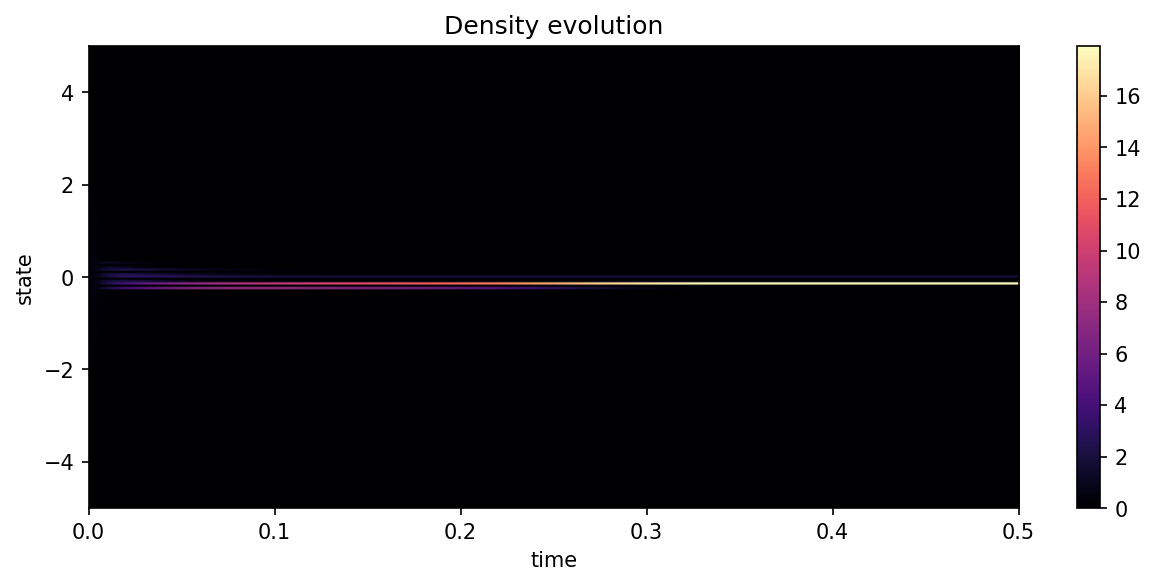

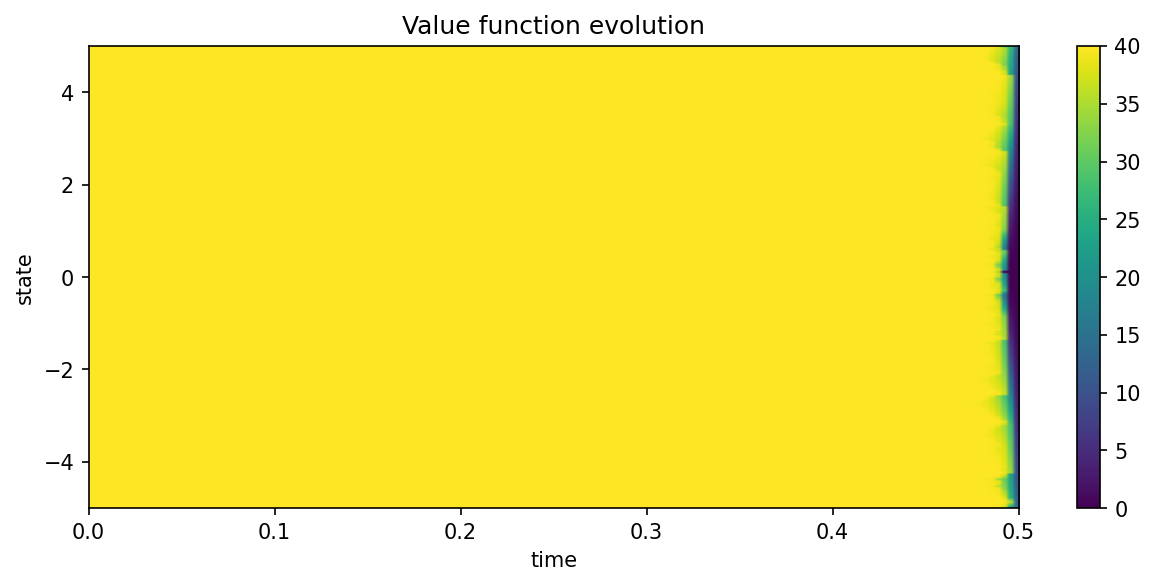

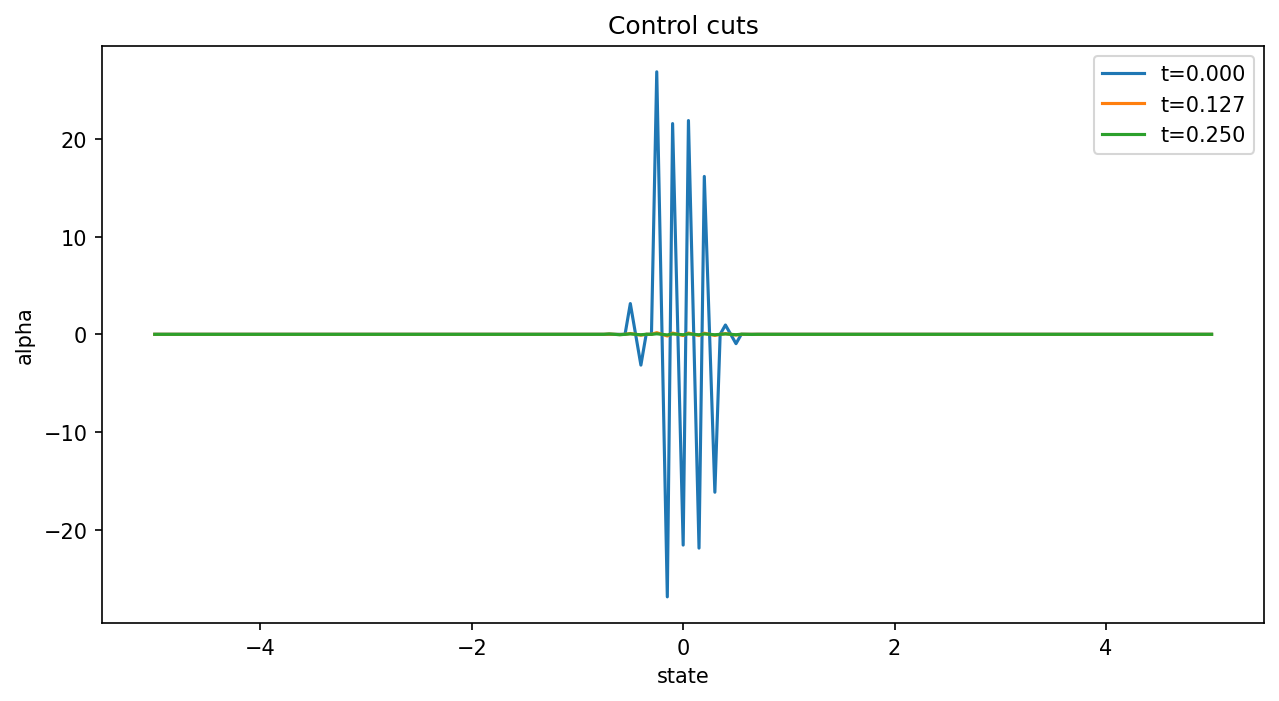

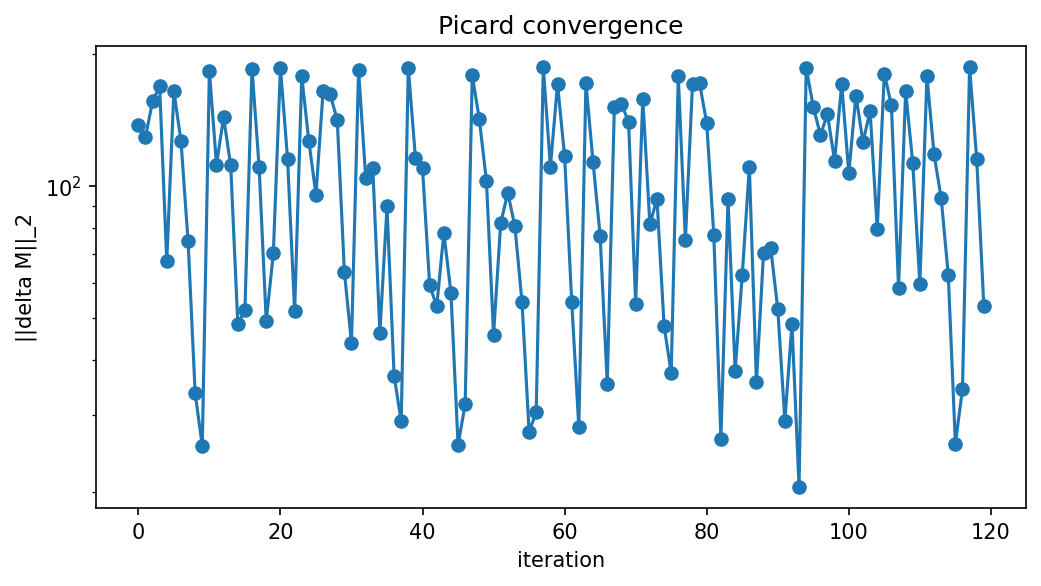

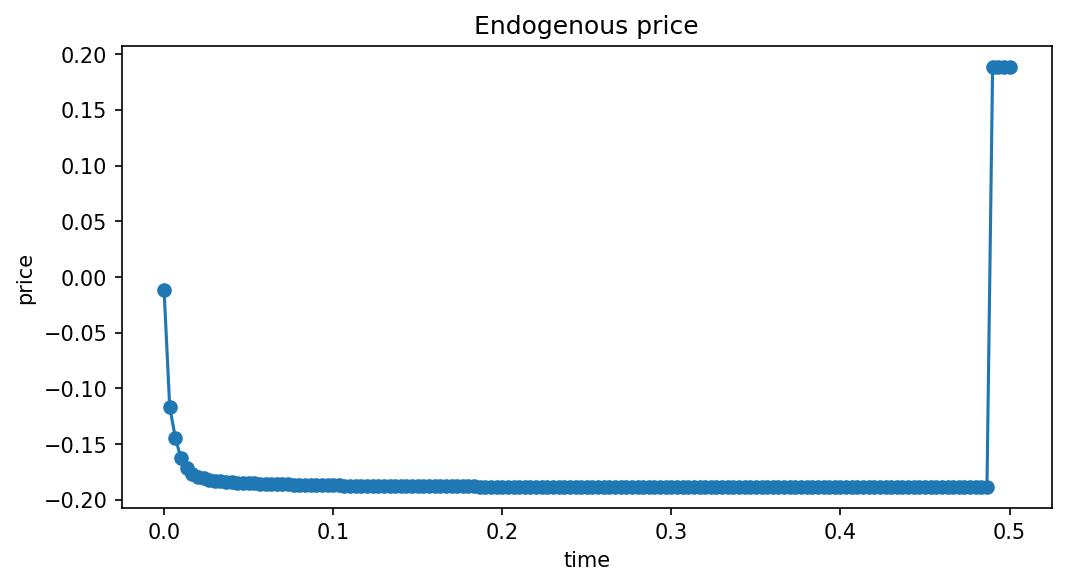

In [18]:
density_path = REPORT_DIR / 'density.png'
value_path = REPORT_DIR / 'value.png'
alpha_path = REPORT_DIR / 'alpha_cuts.png'
conv_path = REPORT_DIR / 'convergence.png'
price_path = REPORT_DIR / 'price.png'

plot_density_time(M_all, grid, density_path)
plot_value_time(U_all, grid, value_path)
plot_alpha_cuts(alpha_all, grid, times=[0.0, 0.25 * grid.T, 0.5 * grid.T], path=alpha_path)
plot_convergence(errors, conv_path)
if price_results is not None:
    plot_price(grid.t, price_results, price_path)

print('Figuras salvas em', REPORT_DIR)
display(Image(filename=density_path))
display(Image(filename=value_path))
display(Image(filename=alpha_path))
display(Image(filename=conv_path))
if price_results is not None:
    display(Image(filename=price_path))


## 9. Resumo final


In [19]:
summary_display = {
    'output_dir': str(REPORT_DIR),
    'iterations': run_metrics.get('iterations'),
    'final_error': run_metrics.get('final_error'),
    'mean_abs_alpha': run_metrics.get('mean_abs_alpha'),
    'std_alpha': run_metrics.get('std_alpha'),
    'liquidity_proxy': run_metrics.get('liquidity_proxy'),
    'price_mean': run_metrics.get('price_mean'),
    'price_std': run_metrics.get('price_std'),
}
print('Resumo final:')
for k, v in summary_display.items():
    print(f'  {k}: {v}')
summary_display
summary_df = pd.DataFrame([summary_display])
display(summary_df)


Resumo final:
  output_dir: c:\Users\Cockles\Documents\GitHub\mfg-for-financial-market\notebooks_output\run-20251019-224426
  iterations: 120
  final_error: 53.28399023368082
  mean_abs_alpha: 0.027159465988757323
  std_alpha: 0.40665119527234683
  liquidity_proxy: 0.9857394247738452
  price_mean: -0.17536829293563666
  price_std: 0.06210999179181633


,output_dir,iterations,final_error,mean_abs_alpha,std_alpha,liquidity_proxy,price_mean,price_std
0,c:\Users\Cockles\Documents\GitHub\mfg-for-fina...,120,53.28399,0.027159,0.406651,0.985739,-0.175368,0.06211


## 10. Interpretando os gráficos
- `density.png`: inventário ao longo do tempo.
- `value.png`: função valor HJB.
- `alpha_cuts.png`: agressividade em diferentes tempos.
- `convergence.png`: evolução do erro.
- `price.png`: preço de clearing (se habilitado).
